In [1]:
import spacy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load('de_core_news_sm')

political_vocabulary = [
    'freiheit',
    'gleich',
    'solidar',
    'sozial',
    'privatisierung',
    'leistung',
    'heimat',
    'mitbestimmung',
    'nachhaltig',
    'umwelt',
    'armut',
    'diskriminier',
    'demokratisier',
    'digital',
]

parties = [
    'afd',
    'cdu_csu',
    'fdp',
    'spd',
    'grüne',
    'linke',
]

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'Der Tagesspiegel',
    'ARD',
    'Tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'ZEIT ONLINE',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

In [2]:
def extract_party_phrase_counts(party):
    with open(f"../assets/manifests/{party}_manifest.txt", encoding="utf-8", errors="ignore") as d:
        manifest = d.read()
    manifest = manifest.replace("0", "")
    manifest = manifest.replace("1", "")
    manifest = manifest.replace("2", "")
    manifest = manifest.replace("3", "")
    manifest = manifest.replace("4", "")
    manifest = manifest.replace("5", "")
    manifest = manifest.replace("6", "")
    manifest = manifest.replace("7", "")
    manifest = manifest.replace("8", "")
    manifest = manifest.replace("9", "")
    manifest = manifest.replace("-\n\n", "")
    manifest = manifest.replace("-\n", "")
    manifest = manifest.replace("\n", " ")
    manifest = manifest.replace("\x0c", " ")
    manifest = manifest.replace(".", " ")
    manifest = manifest.replace(",", " ")
    manifest = manifest.replace("-", "")
    manifest = manifest.replace("•", "")
    manifest = manifest.replace("–", "")
    manifest = manifest.replace(":", "")
    manifest = manifest.replace("%", "")
    manifest = manifest.replace("\"", "")
    manifest = manifest.replace(">", "")
    manifest = manifest.replace("\t", " ")
    manifest = manifest.replace("\x07", "")
    manifest = manifest.replace("\x08", "")
    manifest = manifest.replace("\xad", "")
    manifest = manifest.replace("\xa0", "")
    manifest = manifest.replace("\u200a", "")
    manifest = manifest.replace("?", "")
    manifest = manifest.replace("!", "")
    manifest = manifest.replace("(", "")
    manifest = manifest.replace(")", "")
    manifest = manifest.replace("/", " ")
    manifest = manifest.replace("�", "")
    manifest = manifest.replace("“", "")
    manifest = manifest.replace("„", "")
    manifest = manifest.replace("€", "")
    manifest = manifest.replace("K APITE L", " ")
    manifest = manifest.replace("»", "")
    manifest = manifest.replace("«", "")
    with nlp.select_pipes(enable="lemmatizer"):
        doc = nlp(manifest)
    lemmas = [token.lemma_.lower() for token in doc]
    manifest_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for political_phrase in political_vocabulary:
        for manifest_phrase in manifest_vocabulary:
            if manifest_phrase.__contains__(political_phrase):
                phrase_counts[political_phrase] += 1
    phrase_counts['total'] = len(manifest_vocabulary)
    return pd.Series(phrase_counts)

In [3]:
def extract_medium_phrase_counts(df, medium):
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for doc in df[df['medium'] == medium]['transcript']:
        with nlp.select_pipes(enable="lemmatizer"):
            preprocessed = nlp(doc)
        lemmas = [token.lemma_.lower() for token in preprocessed]
        medium_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
        for political_phrase in political_vocabulary:
            for medium_phrase in medium_vocabulary:
                if medium_phrase.__contains__(political_phrase):
                    phrase_counts[political_phrase] += 1
    return pd.Series(phrase_counts)

In [4]:
phrase_dict = {
    party:extract_party_phrase_counts(party) for party in parties
}
party_df = pd.DataFrame(phrase_dict)

In [5]:
df = pd.read_pickle('../data/topic.pkl')
phrase_dict = {
    medium:extract_medium_phrase_counts(df, medium) for medium in media
}
media_df = pd.DataFrame(phrase_dict)

In [6]:
party_similarity_dict = {}
for party in parties:
    medium_similarity_dict = {}
    for medium in media:
        medium_similarity_dict[medium] = cosine_similarity([party_df[party].iloc[:-1].to_list(), media_df[medium].to_list()])[0, 1]
    medium_series = pd.Series(medium_similarity_dict) 
    party_similarity_dict[party] = medium_series
similarity_df = pd.DataFrame(party_similarity_dict)

[Text(0.5, 50.09375, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'cosine similarity between party manifests and media vocabulary')]

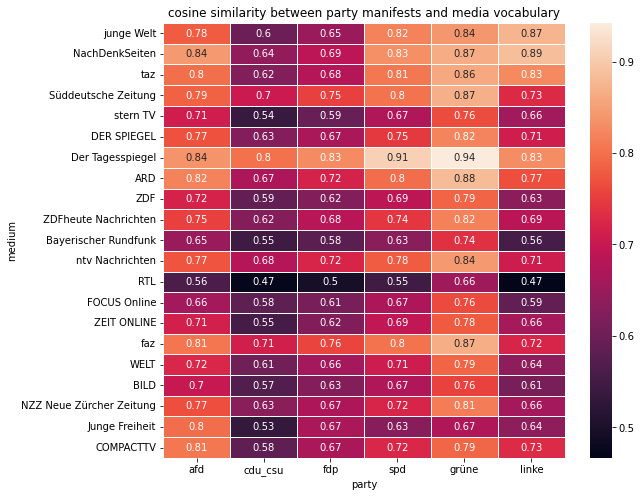

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(similarity_df.drop('Tagesschau'), annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='cosine similarity between party manifests and media vocabulary')

[Text(0.5, 50.09375, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'cosine similarity between party manifests and media vocabulary, standard scaler')]

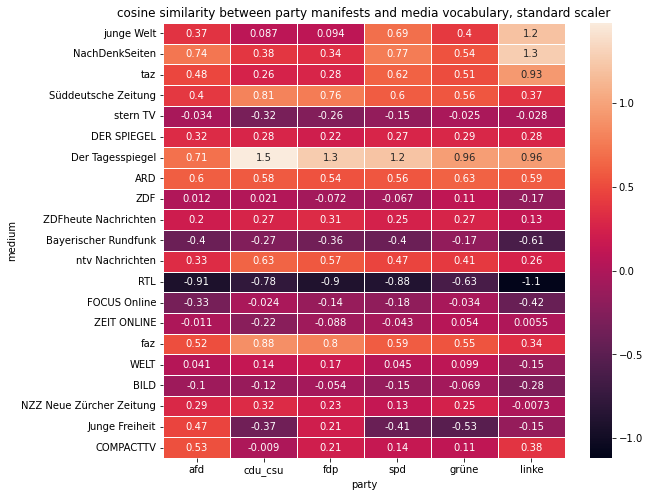

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(similarity_df)
similarity_df_scaled = pd.DataFrame(scaler.transform(similarity_df), columns = similarity_df.columns, index=similarity_df.index)

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(similarity_df_scaled.drop('Tagesschau'), annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='cosine similarity between party manifests and media vocabulary, standard scaler')